# Language Translation with Word Level seq2seq DL Models

The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

![](https://i.imgur.com/So32H7U.png)

We will use German-English sentence pairs data from http://www.manythings.org/anki/


Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

![](https://i.imgur.com/Uk1tCPo.png)

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:
- The encoder 
- The decoder

Both these parts are essentially two different sequential models like RNNs\LSTMs which are combined together.

![](https://i.imgur.com/bT6PAtv.png)

# Download the Dataset

In [ ]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip
!ls -l

--2019-08-05 17:28:05--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   4.33M   976KB/s    in 4.7s    

2019-08-05 17:28:10 (939 KB/s) - ‘deu-eng.zip’ saved [4541707/4541707]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              
total 18232
-rw-r--r-- 1 root root     1441 Jul 21 00:01 _about.txt
-rw-r--r-- 1 root root  4541707 Jul 21 05:56 deu-eng.zip
-rw-r--r-- 1 root root 14118330 Jul 21 00:01 deu.txt
drwxr-xr-x 1 root root     4096 Aug  2 16:06 sample_data


In [ ]:
!pip install tqdm

# Load up the dataset

In [ ]:
import numpy as np

FILE_NAME = './deu.txt'
with open(FILE_NAME, mode='rt', encoding='utf-8') as infile:
  data = infile.read()
  sentences = data.strip().split('\n')
  sentences = [item.split('\t') for item in sentences]
  eng_deu = np.array(sentences)

eng_deu = eng_deu[:50000]
eng_deu

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

In [ ]:
deu = eng_deu[:,1]
eng = eng_deu[:,0]
eng, deu

(array(['Hi.', 'Hi.', 'Run!', ..., 'The man died of cancer.',
        'The man lay motionless.', 'The man must be insane.'],
       dtype='<U537'),
 array(['Hallo!', 'Grüß Gott!', 'Lauf!', ..., 'Der Mann starb an Krebs.',
        'Der Mann lag bewegungslos da.',
        'Der Mann muss geistesgestört sein.'], dtype='<U537'))

# Basic Text Pre-processing

In [ ]:
import string

# Remove punctuation and lowercase
eng = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in eng])
deu = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in deu])
eng, deu

(array(['hi', 'hi', 'run', ..., 'the man died of cancer',
        'the man lay motionless', 'the man must be insane'], dtype='<U22'),
 array(['hallo', 'grüß gott', 'lauf', ..., 'der mann starb an krebs',
        'der mann lag bewegungslos da',
        'der mann muss geistesgestört sein'], dtype='<U118'))

# Viewing Sentence Lengths

In [ ]:
eng_len = [len(s.split()) for s in eng]
deu_len = [len(s.split()) for s in deu]

max(eng_len), max(deu_len)

(7, 17)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea3cd50898>,
      dtype=object)

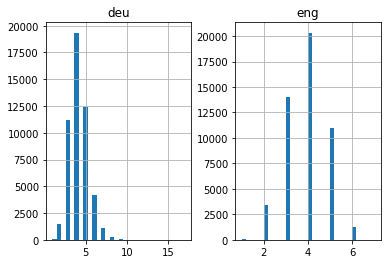

In [ ]:
import pandas as pd
%matplotlib inline

length_df = pd.DataFrame({'eng':eng_len, 'deu':deu_len})
length_df.hist(bins=30)

# Converting Text to Sequences of Numbers

In [ ]:
from tensorflow import keras

eng_tokenizer = keras.preprocessing.text.Tokenizer()
eng_tokenizer.fit_on_texts(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(eng_len)
print('Max eng text length:', eng_length)
print('English Vocabulary Size:', eng_vocab_size)

Max eng text length: 7
English Vocabulary Size: 6352


In [ ]:
deu_tokenizer = keras.preprocessing.text.Tokenizer()
deu_tokenizer.fit_on_texts(deu)
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = max(deu_len)
print('Max deu text length:', deu_length)
print('German Vocabulary Size:', deu_vocab_size)

Max deu text length: 17
German Vocabulary Size: 10678


In [ ]:
from sklearn.model_selection import train_test_split

train_deu, test_deu, train_eng, test_eng = train_test_split(deu, eng, test_size=0.2, random_state = 42)
train_deu.shape, test_deu.shape, train_eng.shape, test_eng.shape

((40000,), (10000,), (40000,), (10000,))

In [ ]:
train_deu, train_eng

(array(['wo sind sie hingegangen', 'rambo existiert nicht',
        'was müssen wir tun', ..., 'tom ist vor einer stunde gegangen',
        'tom strickt', 'tom zieht sich gut an'], dtype='<U118'),
 array(['where have they gone', 'rambo doesnt exist',
        'what do we have to do', ..., 'tom left an hour ago', 'tom knits',
        'tom dresses well'], dtype='<U22'))

### We pad the sequences of texts also to make sure they are of uniform length

In [ ]:
train_deu_enc = deu_tokenizer.texts_to_sequences(train_deu)
train_deu_enc = keras.preprocessing.sequence.pad_sequences(train_deu_enc, maxlen=deu_length, padding='post')

train_eng_enc = eng_tokenizer.texts_to_sequences(train_eng)
train_eng_enc = keras.preprocessing.sequence.pad_sequences(train_eng_enc, maxlen=eng_length, padding='post')

train_deu_enc.shape, train_eng_enc.shape

((40000, 17), (40000, 7))

In [ ]:
test_deu_enc = deu_tokenizer.texts_to_sequences(test_deu)
test_deu_enc = keras.preprocessing.sequence.pad_sequences(test_deu_enc, maxlen=deu_length, padding='post')

test_eng_enc = eng_tokenizer.texts_to_sequences(test_eng)
test_eng_enc = keras.preprocessing.sequence.pad_sequences(test_eng_enc, maxlen=eng_length, padding='post')

test_deu_enc.shape, test_eng_enc.shape

((10000, 17), (10000, 7))

# Build seq2seq Model Architecture

![](https://i.imgur.com/3ZVi97s.png)

- For the encoder, we will use an embedding layer and an LSTM layer
- For the decoder, we will use another LSTM layer followed by a dense layer
- Repeat Vector helps pass the output sequence from encoder to all LSTM cells in the decoder

We leverage the full power of GPUs by using the CUDA variant of the LSTM models.

In [ ]:
EMBEDDING_DIM = 512
LSTM_UNITS = 512

encoder_inputs = keras.layers.Input(shape=(deu_length,))
enc_emb =  keras.layers.Embedding(deu_vocab_size, EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = keras.layers.CuDNNLSTM(LSTM_UNITS)(enc_emb)
rp_vec = keras.layers.RepeatVector(eng_length)(encoder_lstm)

decoder_lstm = keras.layers.CuDNNLSTM(LSTM_UNITS, return_sequences=True)(rp_vec)
decoder_softmax = keras.layers.Dense(eng_vocab_size, activation='softmax')(decoder_lstm)
model = keras.models.Model(inputs=encoder_inputs, outputs=decoder_softmax)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

W0805 17:28:29.253498 140644815132544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 17:28:29.277354 140644815132544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 17, 512)           5467136   
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 512)               2101248   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 512)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 7, 512)            2101248   
_________________________________________________________________
dense (Dense)                (None, 7, 6352)           3258576   
Total params: 12,928,208
Trainable params: 12,928,208
Non-trainable params: 0
_________________________________________________

# Model Training

We save the model with minimum loss here also with checkpointing

In [ ]:
mc = keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_deu_enc, train_eng_enc.reshape(train_eng_enc.shape[0], train_eng_enc.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.1,
          callbacks=[mc], verbose=1)

W0805 17:28:29.654081 140644815132544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 36000 samples, validate on 4000 samples
Epoch 1/50
35840/36000 [============================>.] - ETA: 0s - loss: 3.7648
Epoch 00001: val_loss improved from inf to 3.39901, saving model to my_nmt_model_min_loss.h5
36000/36000 [==============================] - 15s 405us/sample - loss: 3.7631 - val_loss: 3.3990
Epoch 2/50
35840/36000 [============================>.] - ETA: 0s - loss: 3.3517
Epoch 00002: val_loss improved from 3.39901 to 3.35146, saving model to my_nmt_model_min_loss.h5
36000/36000 [==============================] - 7s 193us/sample - loss: 3.3515 - val_loss: 3.3515
Epoch 3/50
35840/36000 [============================>.] - ETA: 0s - loss: 3.2656
Epoch 00003: val_loss improved from 3.35146 to 3.21310, saving model to my_nmt_model_min_loss.h5
36000/36000 [==============================] - 7s 196us/sample - loss: 3.2655 - val_loss: 3.2131
Epoch 4/50
35840/36000 [============================>.] - ETA: 0s - loss: 3.1380
Epoch 00004: val_loss improved from 3.21310 to 3

### We also save the final model to check it's performance

In [ ]:
model.save('my_nmt_model.h5')

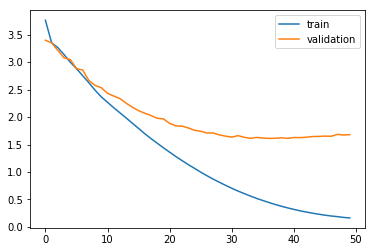

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

# Text Generator

We build a utility function to generate text sequences based on the output prediction sequences

In [ ]:
from tqdm import tqdm
pd.set_option('display.max_colwidth', 500)

eng_idx2word = {v:k for k, v in eng_tokenizer.word_index.items()}

def generate_prediction_texts(pred_seqs, idx2word_map):
  pred_texts = []

  for pred in tqdm(preds):
    temp = []
    for idx in range(len(pred)):
      w = eng_idx2word.get(pred[idx], None)
      if idx > 0:
        if (w == eng_idx2word.get(pred[idx-1], None)) or (w == None):
            temp.append('')
        else:
            temp.append(w)
          
      else:
        if(w == None):
            temp.append('')
        else:
            temp.append(w)            
        
    pred_texts.append(' '.join(temp))
  return pred_texts


# Perform Language Translation with Trained Models

In [ ]:
final_model = keras.models.load_model('./my_nmt_model.h5')
min_loss_model = keras.models.load_model('./my_nmt_model_min_loss.h5')

# Translation on Train Data

### Performance of Final Model on Train Data

In [ ]:
model = final_model
pred_probs = model.predict(train_deu_enc.reshape((train_deu_enc.shape[0], train_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': train_deu, 'target' : train_eng, 'predicted' : pred_texts})

40000/40000 [==============================] - 13s 319us/sample


100%|██████████| 40000/40000 [00:00<00:00, 139748.88it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,wo sind sie hingegangen,rambo existiert nicht,was müssen wir tun,tom hat uns alle gerettet,er hat nicht geantwortet,weiß der himmel warum,ich kenne sie dem namen nach,nach wem sucht tom,ist tom immer noch da,ich habe dieses haus geliebt,tom schrieb maria an,sie fehlen uns sehr,ich lese das etikett,es wird doch einfacher,ich habe es nicht ganz gelesen,das ist sehr hilfreich,ich brauche etwas blaue farbe,es geht nicht um geld,ist meine wäsche fertig,ich werde überleben,hör mir zu,geht es der katze gut,willst du tanzen,ich hole meine tasche,tom sieht schwächer aus,du kannst helfen,ich habe ein radio,du bist eingeladen,tom kann das nicht,kannst du eine schleife binden,es ist nicht von mir,wir werden für dich beten,tom hat schon angefangen,grüß gott,ich brauche einen notizblock,sehen heißt glauben,lasst uns nicht spielen,du kennst es,ich bin toms rivale,ich brauche dich,erzähl mir nichts – zeig’s her,sei vernünftig tom,tom verschied,lese es nach mir,du bist nachlässig,ich brauche etwas papier,hey wie gehts,lies bitte dieses buch,es besteht keinerlei hoffnung,maria ist ein hübsches mädchen
target,where have they gone,rambo doesnt exist,what do we have to do,tom saved us all,he made no reply,heaven knows why,i know her by name,whos tom looking for,is tom still around,i loved that house,tom texted mary,we miss you a lot,i read the label,it does get easier,i didnt read it all,that helps a lot,i need some blue paint,its not about money,is my laundry ready,i will survive,listen to me,is the cat all right,do you want to dance,ill get my bag,tom looks weaker,you can help,i have a radio,youre invited,tom cant do that,can you tie a bow,its not from me,well pray for you,tom has already begun,hi,i need a writing pad,seeing is believing,lets not play,you know her,im toms rival,i need you,dont tell me show me,tom be reasonable,tom passed away,read after me,youre negligent,i need some paper,hey hows it going,please read this book,theres no hope,mary is a pretty girl
predicted,where have they gone,rambo doesnt exist,what do we have to do,tom saved us all,he didnt no reply,heaven knows why,i know her by name,take tom looking for,is tom still around,i loved that house,tom texted mary,we miss you a lot,i read the label,it does get easier,i didnt read it all,this is very lot,i need some blue paint,its not about money,is my laundry ready,i will survive,listen to me,is the cat all right,do you want to dance,ill get my bag,tom looks weaker,you can help,i have a radio,youre invited,tom cant do that,can you tie a bow,its not from me,well pray for you,tom has already begun,hi,i need a writing pad,seeing is believing,lets not play,you know her,im toms rival,i need you,dont tell me show me,tom be reasonable,tom passed away,read after me,youre negligent,i need some paper,hey hows it going,please read this book,theres no hope,mary is a pretty girl


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,ich habe hausaufgaben,tom ist nicht allzu groß,warum bist du zu hause,ich kann das hier nicht öffnen,tom seufzte,er genas wieder,zeigs mir,sie sind nutzlos,er hat einen hund gemalt,glücklicherweise wurde niemand nass,ich habe tom schreien hören,das wird nicht leicht sein,ich verstehe was ihr sagt,ich legte die handtücher zusammen,das ist eine nette feier,tom war ein bisschen nervös,tom bäckt einen kuchen,spinnen spinnen netze,tom entschied sich,muss ich umsteigen,er bekannte sich schuldig,ist das dein haus,er singt gerne,tom kann gut singen,es war unglaublich,sing nicht,du solltest mir danken,das haus steht in flammen,ich habe ihn für tom geschrieben,tom ist aufmerksam,tom kann nicht schwimmen,ich hatte sowieso keinen hunger,ich werde das vielleicht nicht tun,vergiss mich nicht,kann ich sie sprechen,ich gebe spanischunterricht,ich habe mich an das rezept gehalten,wie heiß ist zu heiß,mach deine arbeit zu ende,suchen sie sich einen sitzplatz,ich werde euch mit freude behilflich sein,was habt ihr sonst noch gekauft,tom verlangte mehr,mir ist übel,du leistest einen beitrag,tom handelt mit rauschgift,warum hast du gelogen,ich habe große angst,tom klang glücklich,sie sind bestürzt
target,i have homework,tom isnt very tall,why are you at home,i cant get this open,tom gave a sigh,he got well again,show me,youre useless,he painted a dog,luckily nobody got wet,i heard tom scream,it wont be easy,i hear you,i folded the towels,its a nice party,tom was a bit nervous,tom is baking a cake,spiders spin webs,tom made up his mind,do i need to transfer,he confessed his guilt,is that your house,he loves singing,tom is a good singer,it was unbelievable,dont sing,you should thank me,the house is on fire,i wrote it for tom,tom is observant,tom cant swim,i wasnt hungry anyway,i may not do that,dont forget about me,may i speak to you,i teach spanish,i followed the recipe,how hot is too hot,finish your work,find yourselves a seat,ill gladly help you,what else did you buy,tom demanded more,i feel like vomiting,youre contributing,tom is dealing drugs,why did you lie,im very scared,tom sounded happy,youre upset
predicted,i have homework,tom isnt very tall,why are you at home,i cant get this open,tom gave,he got well again,show me,youre useless,he painted a dog,luckily nobody got wet,i heard tom scream,it wont be easy,i hear you,i folded the towels,its a nice party,tom was a bit nervous,tom is baking a cake,spiders spin webs,tom made up his mind,do i need to transfer,he admitted his guilt,is this your house,he likes to sing,tom is a good,it was unbelievable,dont sing,you should thank me,the house is on fire,i wrote it for tom,tom is attentive,tom cant swim,i wasnt hungry anyway,i may not do that,dont forget about me,may i speak to you,i teach spanish,i followed the recipe,how hot is too hot,finish your work,find yourselves a seat,ill gladly you,what else did you buy,tom demanded more,i feel like vomiting,youre contributing,tom is dealing drugs,why did you lie,im very scared,tom sounded happy,theyre upset


### Performance of Minimum Loss Model on Train Data

In [ ]:
model = min_loss_model
pred_probs = model.predict(train_deu_enc.reshape((train_deu_enc.shape[0], train_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': train_deu, 'target' : train_eng, 'predicted' : pred_texts})

40000/40000 [==============================] - 12s 295us/sample


100%|██████████| 40000/40000 [00:00<00:00, 141351.81it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,wo sind sie hingegangen,rambo existiert nicht,was müssen wir tun,tom hat uns alle gerettet,er hat nicht geantwortet,weiß der himmel warum,ich kenne sie dem namen nach,nach wem sucht tom,ist tom immer noch da,ich habe dieses haus geliebt,tom schrieb maria an,sie fehlen uns sehr,ich lese das etikett,es wird doch einfacher,ich habe es nicht ganz gelesen,das ist sehr hilfreich,ich brauche etwas blaue farbe,es geht nicht um geld,ist meine wäsche fertig,ich werde überleben,hör mir zu,geht es der katze gut,willst du tanzen,ich hole meine tasche,tom sieht schwächer aus,du kannst helfen,ich habe ein radio,du bist eingeladen,tom kann das nicht,kannst du eine schleife binden,es ist nicht von mir,wir werden für dich beten,tom hat schon angefangen,grüß gott,ich brauche einen notizblock,sehen heißt glauben,lasst uns nicht spielen,du kennst es,ich bin toms rivale,ich brauche dich,erzähl mir nichts – zeig’s her,sei vernünftig tom,tom verschied,lese es nach mir,du bist nachlässig,ich brauche etwas papier,hey wie gehts,lies bitte dieses buch,es besteht keinerlei hoffnung,maria ist ein hübsches mädchen
target,where have they gone,rambo doesnt exist,what do we have to do,tom saved us all,he made no reply,heaven knows why,i know her by name,whos tom looking for,is tom still around,i loved that house,tom texted mary,we miss you a lot,i read the label,it does get easier,i didnt read it all,that helps a lot,i need some blue paint,its not about money,is my laundry ready,i will survive,listen to me,is the cat all right,do you want to dance,ill get my bag,tom looks weaker,you can help,i have a radio,youre invited,tom cant do that,can you tie a bow,its not from me,well pray for you,tom has already begun,hi,i need a writing pad,seeing is believing,lets not play,you know her,im toms rival,i need you,dont tell me show me,tom be reasonable,tom passed away,read after me,youre negligent,i need some paper,hey hows it going,please read this book,theres no hope,mary is a pretty girl
predicted,where did they gone,rambo doesnt exist,what do we have to do,tom saved us all,he didnt no reply,thats knows why,i know her by name,take tom to for,is tom still there,i loved that house,tom gave mary,we miss you a much,i read the label,it will get easier,i didnt read it all,this is a helpful,i need some blue paint,its not on money,is my laundry ready,i will survive,listen to me,is the cat right,do you want to dance,ill am my bag,tom looks weaker,you can help,i have a radio,youre invited,tom cant do that,can you tie a bow,its not for me,well pray you,tom has already begun,hi an,i need a writing pad,kids is believing,lets not play,you know that,im toms rival,i need you,dont tell me show me,tom be reasonable,tom passed away,break after me,youre negligent,i need some paper,hey hows it,please read that book,theres no hope,mary is a pretty girl


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,ich habe hausaufgaben,tom ist nicht allzu groß,warum bist du zu hause,ich kann das hier nicht öffnen,tom seufzte,er genas wieder,zeigs mir,sie sind nutzlos,er hat einen hund gemalt,glücklicherweise wurde niemand nass,ich habe tom schreien hören,das wird nicht leicht sein,ich verstehe was ihr sagt,ich legte die handtücher zusammen,das ist eine nette feier,tom war ein bisschen nervös,tom bäckt einen kuchen,spinnen spinnen netze,tom entschied sich,muss ich umsteigen,er bekannte sich schuldig,ist das dein haus,er singt gerne,tom kann gut singen,es war unglaublich,sing nicht,du solltest mir danken,das haus steht in flammen,ich habe ihn für tom geschrieben,tom ist aufmerksam,tom kann nicht schwimmen,ich hatte sowieso keinen hunger,ich werde das vielleicht nicht tun,vergiss mich nicht,kann ich sie sprechen,ich gebe spanischunterricht,ich habe mich an das rezept gehalten,wie heiß ist zu heiß,mach deine arbeit zu ende,suchen sie sich einen sitzplatz,ich werde euch mit freude behilflich sein,was habt ihr sonst noch gekauft,tom verlangte mehr,mir ist übel,du leistest einen beitrag,tom handelt mit rauschgift,warum hast du gelogen,ich habe große angst,tom klang glücklich,sie sind bestürzt
target,i have homework,tom isnt very tall,why are you at home,i cant get this open,tom gave a sigh,he got well again,show me,youre useless,he painted a dog,luckily nobody got wet,i heard tom scream,it wont be easy,i hear you,i folded the towels,its a nice party,tom was a bit nervous,tom is baking a cake,spiders spin webs,tom made up his mind,do i need to transfer,he confessed his guilt,is that your house,he loves singing,tom is a good singer,it was unbelievable,dont sing,you should thank me,the house is on fire,i wrote it for tom,tom is observant,tom cant swim,i wasnt hungry anyway,i may not do that,dont forget about me,may i speak to you,i teach spanish,i followed the recipe,how hot is too hot,finish your work,find yourselves a seat,ill gladly help you,what else did you buy,tom demanded more,i feel like vomiting,youre contributing,tom is dealing drugs,why did you lie,im very scared,tom sounded happy,youre upset
predicted,i have homework,tom isnt very tall,why are you at home,i cant do this open,tom sighed,he got well again,show me,youre useless,he painted a dog,luckily nobody got wet,i heard tom scream,it wont be easy,i what you,i folded the towels,its a nice party,tom was a bit nervous,tom is baking a cake,spiders spin webs,tom gave his,do i need to transfer,he admitted his guilt,is this your house,he likes singing,tom is be at cook,it was unbelievable,dont be,you should thank me,the house is on fire,i wrote it for tom,tom is attentive,tom cant swim,i wasnt hungry,i wont not do that,dont forget about me,can i speak to you,i teach spanish,i followed the recipe,how hot is hot,finish your work to,get a seat,ill gladly you to,what else did you buy,tom demanded more,i feel like vomiting,youre contributing,tom is full drugs,why did you lie,im very scared,tom sounded happy,theyre upset


# Translation on Test Data

### Performance of Final Model on Test Data

In [ ]:
model = final_model
pred_probs = model.predict(test_deu_enc.reshape((test_deu_enc.shape[0], test_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': test_deu, 'target' : test_eng, 'predicted' : pred_texts})

10000/10000 [==============================] - 3s 297us/sample


100%|██████████| 10000/10000 [00:00<00:00, 135825.03it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,du bist zu großzügig,nun kommen sie schon herein,wachen sie auf,wir haben dir geglaubt,ihr habt mir nie vertraut,lass dich umarmen,es ist wirklich tom,sie bat ihn um hilfe,was ist liebe,erzähl mir wie du dich fühlst,sie hat versucht sich selbst umzubringen,wir halfen einander,wer hat geantwortet,fangen sie hier an,ich habe es nicht bekommen,ich habe schlechte augen,rotwein bitte,frag ruhig tom,was ist uns bekannt,tom verkauft schuhe,wir sind dabei zu lesen,tom hat sich weh getan,hör mal auf damit,es sterben menschen,steig auf das pferd,tom sah aufgeregt aus,ich bin toms großmutter,ich muss es finden,der text ist zu lang,wer hat den apfel gestohlen,maria ist die schwester von tom,ich verspreche ich werde mir mühe geben,hören sie auf zu schießen,tom ist da,tom war nie ungerecht,tom ist nicht hier oben,nimm was du willst,ich bin sehr enttäuscht,ich weiß nicht wer es ist,setze deinen hut auf,ich will einfach nur deine liebe,was werden sie machen,schließe die augen,tom scheint entschlossen,hat die bar schon geöffnet,ich mag euren hund nicht,ist tom so gut,tom ist auf dem hof,hast du brötchen mitgebracht,warnung vor dem hunde
target,youre too generous,come in already,wake up,we believed you,you never trusted me,let me give you a hug,its really tom,she asked him for help,what is love,tell me how you feel,she attempted suicide,we helped each other,who responded,start here,i couldnt get it,i have bad eyesight,red wine please,go ahead and ask tom,what do we know,tom sells shoes,were reading,tom hurt himself,stop that,people are dying,get on the horse,tom looked excited,im toms grandmother,ive got to find it,the text is too long,who stole the apple,mary is toms sister,i promise ill try,stop shooting,tom is there,tom was never unfair,tom isnt up here,take anything you like,im very disappointed,i dont know who it is,put on your hat,i just want your love,what will they do,close your eyes,tom seems determined,is the bar open yet,i dont like your dog,is tom that good,tom is in the yard,did you bring rolls,beware of the dog
predicted,youre quite,come in,take them,we talked betrayed,you never trusted me,go for,its really tom,she asked him for help,whats is,you me you,she listens suicide,we helped one another,who surrendered,get here,i didnt get it,i have hurts eyes,red wine please,ask tom,what do they know,tom opened his shoes,were on this,tom got,stop that this,thats change,leave the car,tom looked them,im toms guest,i have find it,that is good,who the apple,mary is toms sister,i hope to go,stop shooting,toms is,tom wasnt was,tom is in,take whatever you want,im very disappointed,i know what its,put your hat on,i just want your job,what will you do,close your eyes,tom looks bottom,is the boat,i dont like your dog,is tom good,tom is on recovery,did you bring rolls,hold the dogs


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,ich kann es selbst machen,kennst du das nicht,unterstützt tom,nicht jeder ist ehrlich,die kennen mich,ich bin hier drüben,ich mag keinen kaffee,meine schwester ist berühmt,mit mir geht das in ordnung,tom gab keinen kommentar ab,ich werde tom warnen,gehen sie weiter geradeaus,das habe ich nicht gesagt,tom ist der wahre held,ich dachte ich hätte euch gehört,wir müssen es finden,sag tom er soll sich erholen,tom ist polizist,er angelt sehr gern,dieses buch ist klein,vorsicht vor dem hund,höre auf mich anzustarren,ich dachte du kanntest tom,bietet sonst noch jemand,tom begann zu schnarchen,ist er daheim,sie müssen sich ausruhen,tom ist dreißig,ich habe mich mit tom gestritten,du bist betrunken,ich finde die farbe fürchterlich,tom ist schüchtern,er kann ihn nicht aufhalten,ich will dass du tanzt,ich sehe gerade fern,er starb als glücklicher mann,ich trage oft blau,sagt tom was los ist,mögen sie keine mädchen,tom hat das viel gemacht,ich habe gezögert,wer hat hier pizza bestellt,tom hat die idee abgelehnt,sie ist noch unmündig,ich habe eine beschwerde,ich esse gerne berliner,habt ihr tom den grund genannt,mir tut diese entscheidung leid,er war untröstlich,küss mich
target,i can do it myself,dont you know that,help tom out,not everyone is honest,they know me,im over here,i dont like coffee,my sister is famous,thats ok with me,tom made no comment,ill warn tom,keep going straight,i didnt say that,tom is the real hero,i thought i heard you,wed better find it,tell tom to relax,tom is a policeman,he loves to fish,that book is small,beware of the dog,stop staring at me,i thought you knew tom,is anyone else bidding,tom started snoring,is he at home,you have to rest,toms thirty,i argued with tom,youre drunk,i hate that color,toms shy,he cannot stop him,i want you to dance,im watching tv now,he died a happy man,i often wear blue,tell tom whats wrong,dont you like girls,tom did that a lot,i hesitated,who ordered pizza,tom rejected the idea,shes still under age,i have a complaint,i like doughnuts,did tom tell you why,i regret that decision,he was heartbroken,give me a kiss
predicted,i can do it,dont you know,tom lose,dont be,they know you,im is over,i dont like coffee,her sister is canadian,im doing here,tom taught me,ill ask tom,keep on straight,i didnt say that,tom is the real man,i thought i heard you,we have to find it,tell tom to relax,tom is a stabbed,he loves to,this book is small,look at the dog,stop staring at me,i saw tom loved tom,nobody anyone,tom began to snore,is he at home,you need to rest,tom is thirty,i was with tom,you drunk,i bet this bet,tom is shy,he cannot stop him,i want you to have,i am watching tv,he is kind happy,i often an,tell tom whats wrong,dont you like girls,tom did a lot,i have,who brought your lunch,tom idea the idea,she still,i have a complaint,i like donuts,did tom tell you why,i feel that name,he was stoned,do call


### Performance of Minimum Loss Model on Test Data

In [ ]:
model = min_loss_model
pred_probs = model.predict(test_deu_enc.reshape((test_deu_enc.shape[0], test_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': test_deu, 'target' : test_eng, 'predicted' : pred_texts})

10000/10000 [==============================] - 3s 301us/sample


100%|██████████| 10000/10000 [00:00<00:00, 134817.40it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,du bist zu großzügig,nun kommen sie schon herein,wachen sie auf,wir haben dir geglaubt,ihr habt mir nie vertraut,lass dich umarmen,es ist wirklich tom,sie bat ihn um hilfe,was ist liebe,erzähl mir wie du dich fühlst,sie hat versucht sich selbst umzubringen,wir halfen einander,wer hat geantwortet,fangen sie hier an,ich habe es nicht bekommen,ich habe schlechte augen,rotwein bitte,frag ruhig tom,was ist uns bekannt,tom verkauft schuhe,wir sind dabei zu lesen,tom hat sich weh getan,hör mal auf damit,es sterben menschen,steig auf das pferd,tom sah aufgeregt aus,ich bin toms großmutter,ich muss es finden,der text ist zu lang,wer hat den apfel gestohlen,maria ist die schwester von tom,ich verspreche ich werde mir mühe geben,hören sie auf zu schießen,tom ist da,tom war nie ungerecht,tom ist nicht hier oben,nimm was du willst,ich bin sehr enttäuscht,ich weiß nicht wer es ist,setze deinen hut auf,ich will einfach nur deine liebe,was werden sie machen,schließe die augen,tom scheint entschlossen,hat die bar schon geöffnet,ich mag euren hund nicht,ist tom so gut,tom ist auf dem hof,hast du brötchen mitgebracht,warnung vor dem hunde
target,youre too generous,come in already,wake up,we believed you,you never trusted me,let me give you a hug,its really tom,she asked him for help,what is love,tell me how you feel,she attempted suicide,we helped each other,who responded,start here,i couldnt get it,i have bad eyesight,red wine please,go ahead and ask tom,what do we know,tom sells shoes,were reading,tom hurt himself,stop that,people are dying,get on the horse,tom looked excited,im toms grandmother,ive got to find it,the text is too long,who stole the apple,mary is toms sister,i promise ill try,stop shooting,tom is there,tom was never unfair,tom isnt up here,take anything you like,im very disappointed,i dont know who it is,put on your hat,i just want your love,what will they do,close your eyes,tom seems determined,is the bar open yet,i dont like your dog,is tom that good,tom is in the yard,did you bring rolls,beware of the dog
predicted,youre grown,come and,take them,we talked you,you never trusted me,let to help,its really tom,she asked him for help,whats this,you me you,she tried suicide,we helped one another,who has,get here,i didnt get it up,i have a eyes,red wine please,go tom,what did they know,tom opened his shoes,were on,tom has got,stop care that,we will,take the horse,tom looked excited,im toms single,i must find it,this is good much,who the apple,mary is toms wife,i said to go,stop complaining,tom is there,tom wasnt was,tom isnt in,take what you want,im very,i know it,put your hat on,i dont want a job,what will you do,close your eyes,tom looks awkward,is the ball,i dont like your dog,is tom good,tom is on his,did you bring rolls,roll the hands well


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,ich kann es selbst machen,kennst du das nicht,unterstützt tom,nicht jeder ist ehrlich,die kennen mich,ich bin hier drüben,ich mag keinen kaffee,meine schwester ist berühmt,mit mir geht das in ordnung,tom gab keinen kommentar ab,ich werde tom warnen,gehen sie weiter geradeaus,das habe ich nicht gesagt,tom ist der wahre held,ich dachte ich hätte euch gehört,wir müssen es finden,sag tom er soll sich erholen,tom ist polizist,er angelt sehr gern,dieses buch ist klein,vorsicht vor dem hund,höre auf mich anzustarren,ich dachte du kanntest tom,bietet sonst noch jemand,tom begann zu schnarchen,ist er daheim,sie müssen sich ausruhen,tom ist dreißig,ich habe mich mit tom gestritten,du bist betrunken,ich finde die farbe fürchterlich,tom ist schüchtern,er kann ihn nicht aufhalten,ich will dass du tanzt,ich sehe gerade fern,er starb als glücklicher mann,ich trage oft blau,sagt tom was los ist,mögen sie keine mädchen,tom hat das viel gemacht,ich habe gezögert,wer hat hier pizza bestellt,tom hat die idee abgelehnt,sie ist noch unmündig,ich habe eine beschwerde,ich esse gerne berliner,habt ihr tom den grund genannt,mir tut diese entscheidung leid,er war untröstlich,küss mich
target,i can do it myself,dont you know that,help tom out,not everyone is honest,they know me,im over here,i dont like coffee,my sister is famous,thats ok with me,tom made no comment,ill warn tom,keep going straight,i didnt say that,tom is the real hero,i thought i heard you,wed better find it,tell tom to relax,tom is a policeman,he loves to fish,that book is small,beware of the dog,stop staring at me,i thought you knew tom,is anyone else bidding,tom started snoring,is he at home,you have to rest,toms thirty,i argued with tom,youre drunk,i hate that color,toms shy,he cannot stop him,i want you to dance,im watching tv now,he died a happy man,i often wear blue,tell tom whats wrong,dont you like girls,tom did that a lot,i hesitated,who ordered pizza,tom rejected the idea,shes still under age,i have a complaint,i like doughnuts,did tom tell you why,i regret that decision,he was heartbroken,give me a kiss
predicted,i can do it,dont you know that,tom get tom,dont be,they know me,im just ready,i dont like cats,her sister is canadian,im doing here,tom taught me,ill ask tom,keep to straight,i didnt what that,tom is our son man,i thought i heard you,we have to find it,tell tom to relax,tom is a guard,he loves fishing,this book is small,just at the dog,stop staring at me,i thought tom,no anybody else,tom began to snore,is he from for home,you need to rest,tom is deceitful,i was with tom,youre drunk,i bet the rug,tom is shy,he cannot stop him,i want you to have,i going to tv,he is an man,i often an,tell tom whats hes,dont like girls,tom did that a purpose,i have,who brought your lunch,tom is the idea,she is still,i have a complaint,i like donuts,did you tell tom,i feel that name,he was naive,are help to
